In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, StackingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('./data/cleanedcheapclean.csv')
df.head()

,Unnamed: 0,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage,workclass_ Federal-gov,workclass_ Local-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0,56,346033,5,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,28,96226,9,0,0,45,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,33,251120,13,7688,0,50,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3,26,178140,13,0,0,45,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,4,40,56795,14,14084,0,55,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [6]:
X = df.drop(columns=['wage'])
y = df['wage']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [35]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('model', LogisticRegression(max_iter=1_000))
])

In [39]:
params = {
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs'],
    'model__C': [1],
    'model__fit_intercept': [True],
    'model__class_weight': [None],
    'model__multi_class': ['auto'],
    'model__warm_start': [False],
    'model__random_state': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
}
gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8484881789351814


{'model__C': 1,
 'model__class_weight': None,
 'model__fit_intercept': True,
 'model__multi_class': 'auto',
 'model__penalty': 'l2',
 'model__random_state': 1,
 'model__solver': 'lbfgs',
 'model__warm_start': False}

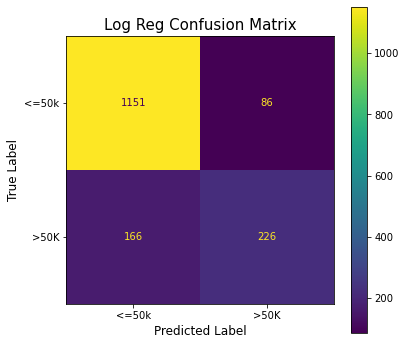

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(gs, X_test, y_test, display_labels=['<=50k', '>50K'], ax=ax)
plt.title('Log Reg Confusion Matrix', size=15)
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12);

In [43]:
gspreds = gs.predict(X_train)

In [45]:
gspredstest = gs.predict(X_test)

In [44]:
f1_score(y_train, gspreds)

0.6729500471253534

In [46]:
f1_score(y_test, gspredstest)

0.6420454545454546

# Stack Model

In [52]:
level_1_models = [
    ('logreg_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=1_000))
    ])),          
     ('knn_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=26, metric='manhattan', weights='uniform'))
    ])),
     ('gb', GradientBoostingClassifier(loss='exponential', learning_rate=.15, 
                                       n_estimators=100, subsample=1.0, min_samples_leaf=1)),
     ('rf', RandomForestClassifier(criterion= 'entropy', max_features= 'auto', n_estimators= 100))
]

stackgb = StackingClassifier(estimators=level_1_models, final_estimator=GradientBoostingClassifier())
stacklogreg = StackingClassifier(estimators=level_1_models, final_estimator=LogisticRegression())
stackknn = StackingClassifier(estimators=level_1_models, final_estimator=KNeighborsClassifier())
stackrf = StackingClassifier(estimators=level_1_models, final_estimator=RandomForestClassifier())

In [53]:
cross_val_score(stackgb, X_train, y_train).mean()

0.8529917613302684

In [54]:
cross_val_score(stacklogreg, X_train, y_train).mean()

0.8558580968840713

In [55]:
cross_val_score(stackknn, X_train, y_train).mean()

0.8421357199187879

In [56]:
cross_val_score(stackrf, X_train, y_train).mean()

0.8417294494689329

In [58]:
stacklogreg.fit(X_train, y_train);

In [69]:
xtestpreds = stacklogreg.predict(X_test)

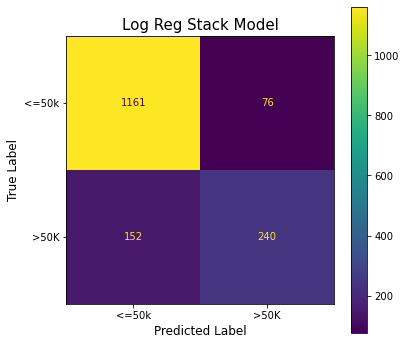

In [59]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(stacklogreg, X_test, y_test, display_labels=['<=50k', '>50K'], cmap='viridis', ax=ax)
plt.title('Log Reg Stack Model', size=15)
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12);

In [60]:
tn1, fp1, fn1, tp1 = 1161, 76, 152, 240

### Accuracy

In [61]:
(tn1 + tp1) / (tn1 +tp1 + fp1 + fn1)

0.860036832412523

### Specificity

In [62]:
tn1 / (tn1 + fp1)

0.9385610347615198

### Sensitivity

In [83]:
recall = tp1 / (tp1 + fn1)

### Precision

In [82]:
precision = tp1 / (tp1 + fp1)

### F1 Score

In [70]:
f1_score(y_test, xtestpreds)

0.6779661016949152

In [72]:
import sklearn.metrics as metrics

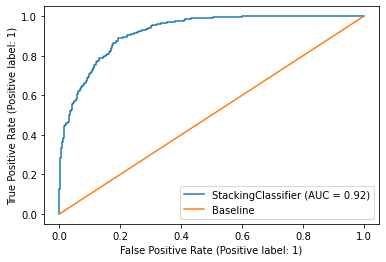

In [73]:
# ROC curve
metrics.plot_roc_curve(stacklogreg, X_test, y_test)
# add worst case scenario line
plt.plot([0,1], [0,1], label='Baseline')
# add a legend
plt.legend();

In [77]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': stacklogreg.predict_proba(X_test)[:,1]}) # want 2nd column here

pred_df.head()

,true_values,pred_probs
1668,0,0.046458
2031,0,0.040897
5781,0,0.044846
988,0,0.041674
1823,0,0.071194


C:\Users\Spencer\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


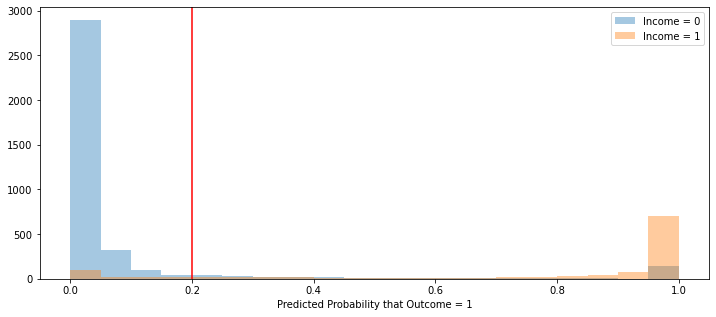

In [104]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Income = {group[0]}')

# Add cutoff line
plt.axvline(.2, color='red')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

In [75]:
prob_list = stacklogreg.predict_proba(X_test)[:,1]

In [80]:
cutoff = .2
conservative_predictions = np.where(prob_list > cutoff, 1, 0)
conservative_predictions

array([0, 0, 0, ..., 1, 0, 0])

In [81]:
conservative_preds = (prob_list > cutoff).astype(int)

In [84]:
recall, metrics.recall_score(y_test, conservative_preds) # recall goes up as cutoff goes down

(0.6122448979591837, 0.8418367346938775)

In [85]:
precision, metrics.precision_score(y_test, conservative_preds) # precision goes down as cutoff goes down

(0.759493670886076, 0.6066176470588235)

In [86]:
cutoff = .3
conservative_predictions1 = np.where(prob_list > cutoff, 1, 0)
conservative_predictions1

array([0, 0, 0, ..., 1, 0, 0])

In [87]:
conservative_preds1 = (prob_list > cutoff).astype(int)

In [88]:
recall, metrics.recall_score(y_test, conservative_preds1)

(0.6122448979591837, 0.7525510204081632)

In [89]:
precision, metrics.precision_score(y_test, conservative_preds1)

(0.759493670886076, 0.676605504587156)

In [91]:
pred_df['conservative_predictions'] = conservative_predictions1

In [93]:
pred_df.corr()

,true_values,pred_probs,conservative_predictions
true_values,1.000000,0.682622,0.616552
pred_probs,0.682622,1.000000,0.906460
conservative_predictions,0.616552,0.906460,1.000000
